In [31]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage.filters
import skimage.segmentation
import skimage.measure
import glob
import random

# Image show

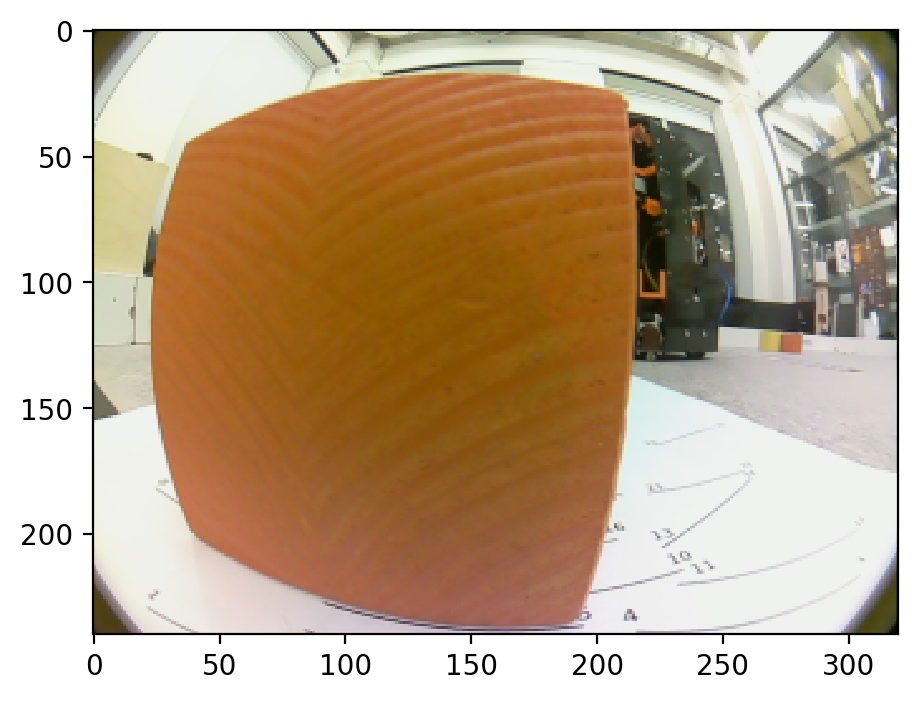

In [2]:
raw_img = cv2.cvtColor(cv2.imread("imgs/1_5.png"), cv2.COLOR_BGR2RGB) 
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(raw_img);

# Undistorte image

In [18]:
K=np.array([[543.107811968841, 0.0, 630.7227631662455], [0.0, 540.0320855865099, 486.5749791589516], [0.0, 0.0, 1.0]])
D=np.array([[-0.05195582161040964], [-0.009477421485536482], [0.010893416415594874], [-0.005379345567357744]])
K1 = K.copy()
K1[:2] /= 4
K2 = K1.copy()
K2[:2, :2] /= 2

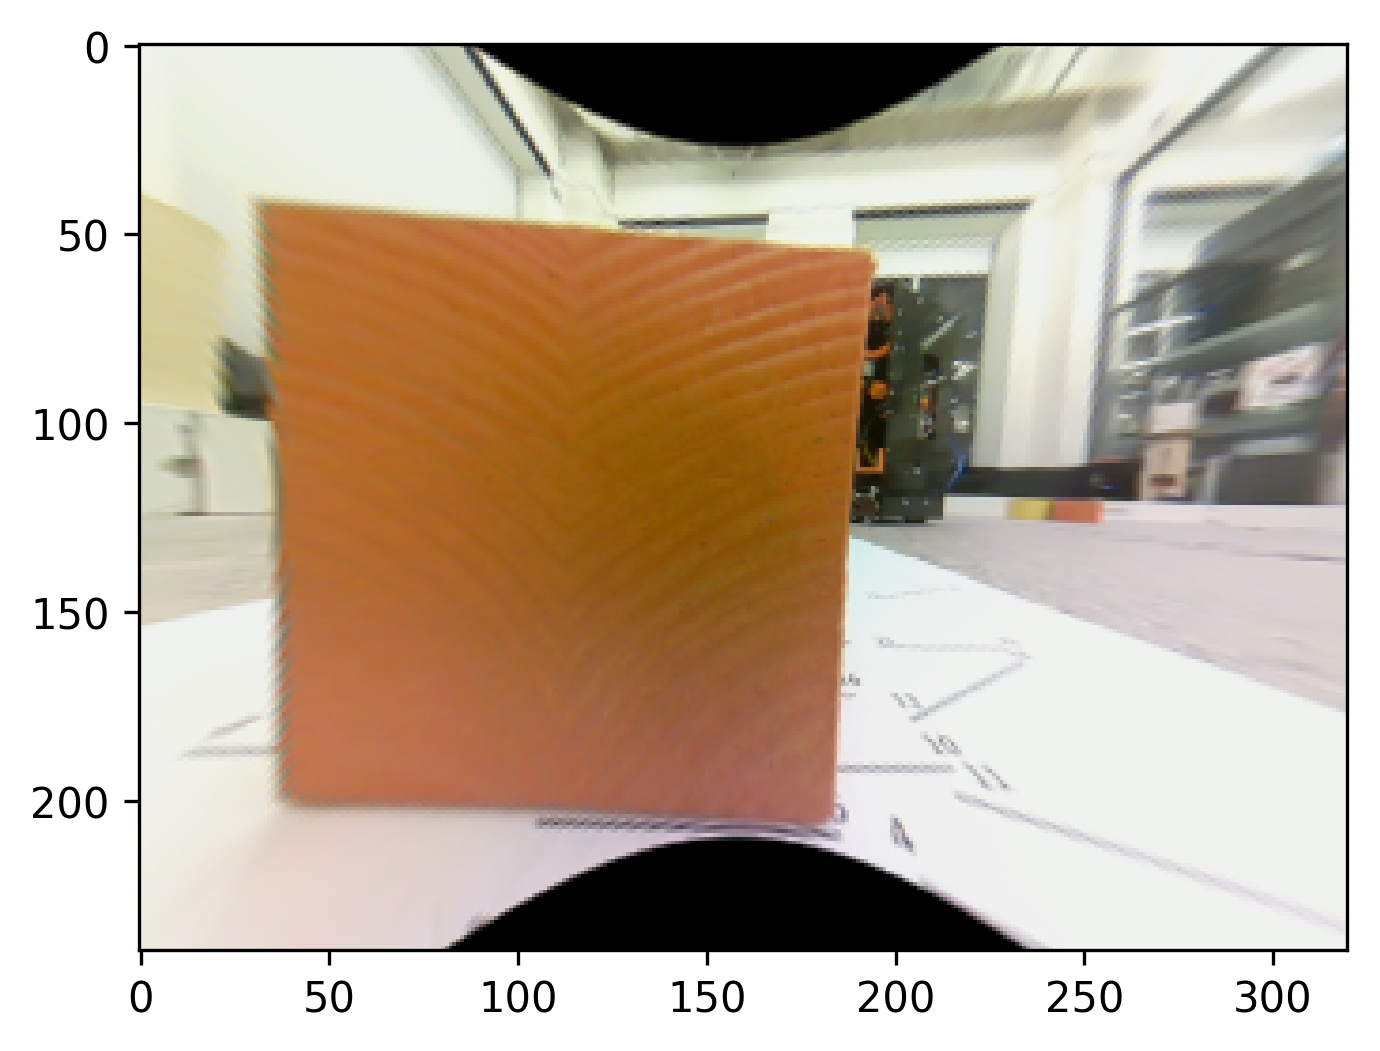

In [19]:
undisort_img = cv2.fisheye.undistortImage(raw_img, K1, D, Knew = K2)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
plt.imshow(undisort_img);

# Smoothing

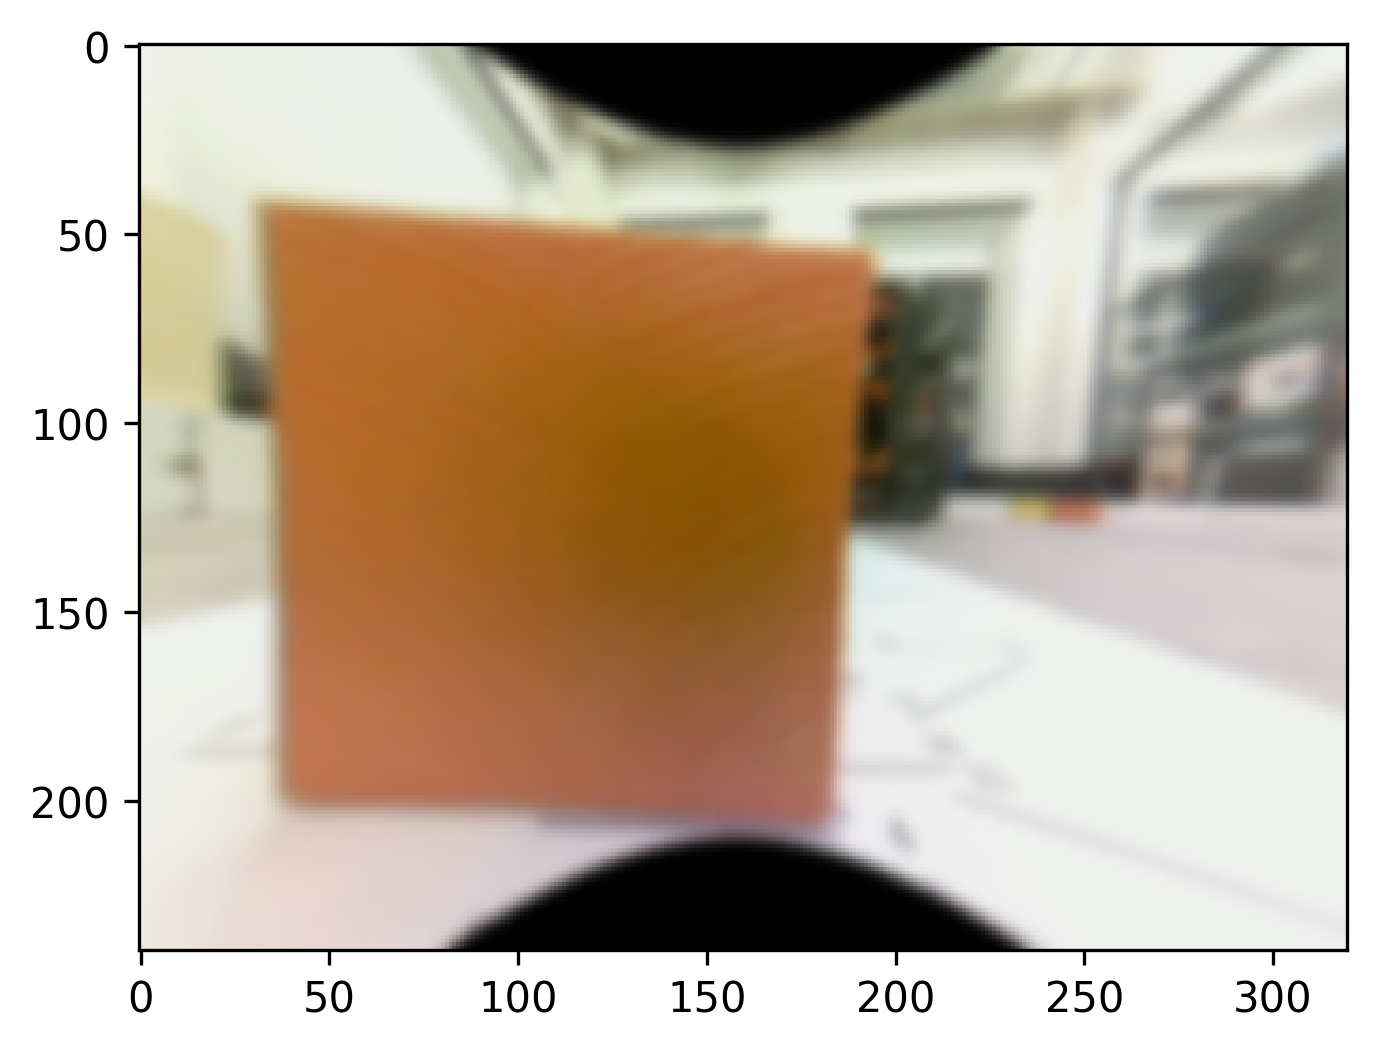

In [58]:
smooth_img = np.zeros_like(undisort_img, dtype=np.float32)
for c in range(3):
    smooth_img[:, :, c] = skimage.filters.gaussian(undisort_img[:, :, c], sigma=2)
smooth_img = (255 * smooth_img).astype(np.uint8)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
plt.imshow(smooth_img);

# Segmentation

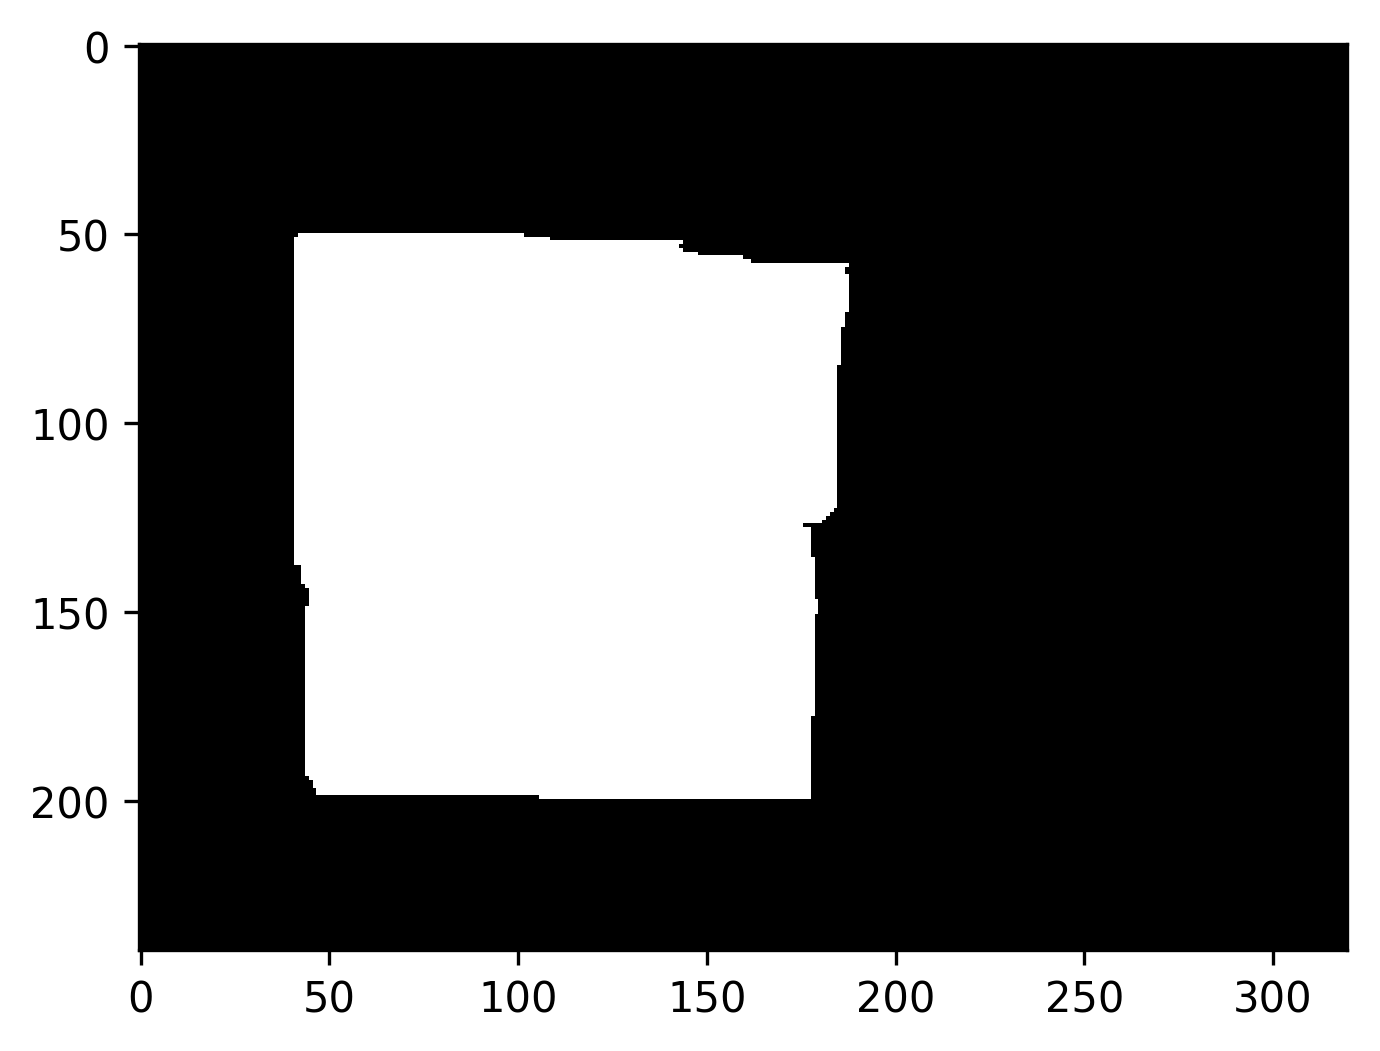

In [52]:
segments = skimage.segmentation.felzenszwalb(undisort_img, scale=120, sigma=3, min_size=30)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
plt.imshow(segments==segments[150, 150], cmap="gray");

In [53]:
def get_params(labels):
    h, w = labels.shape[0:2]
    x = np.arange(w)
    y = np.arange(h)
    m = np.count_nonzero(labels)
    xc = np.sum(x[np.newaxis, :] * (labels)) / m
    yc = np.sum(y[:, np.newaxis] * (labels)) / m
    return int(m ** 0.5), int(xc), int(yc)
side, xc, yc = get_params(segments==segments[150, 150])

# Many images

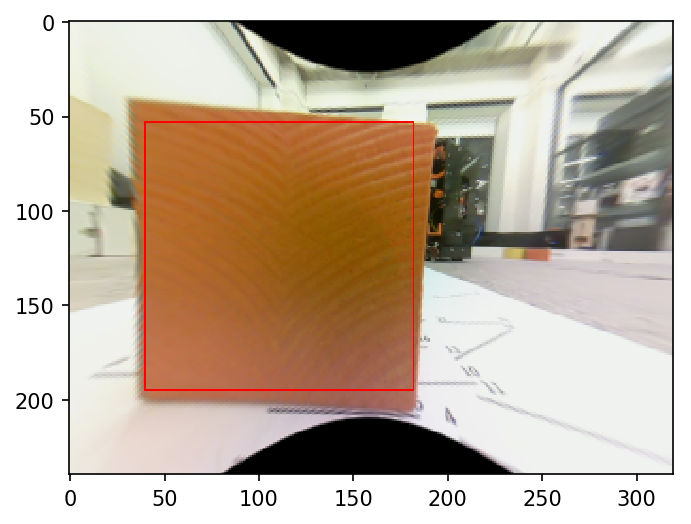

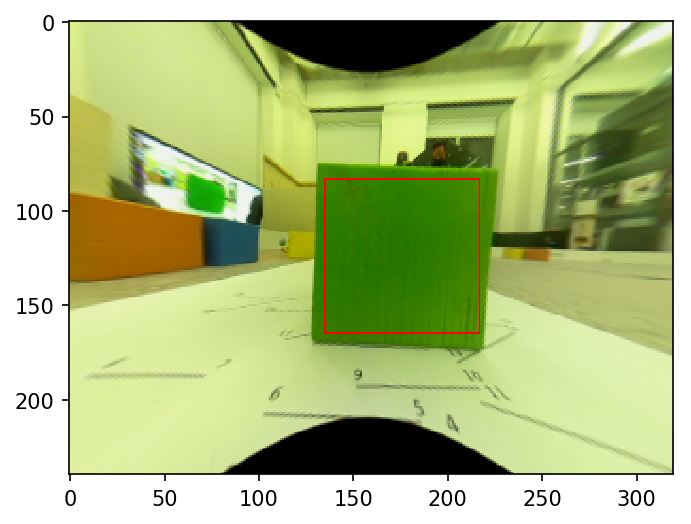

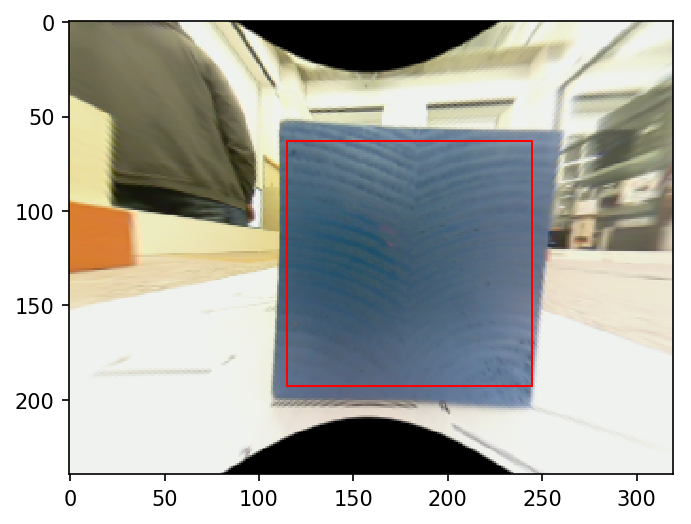

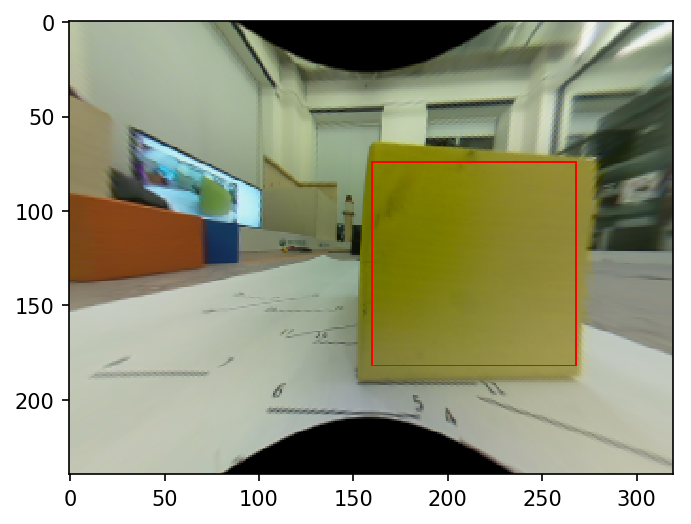

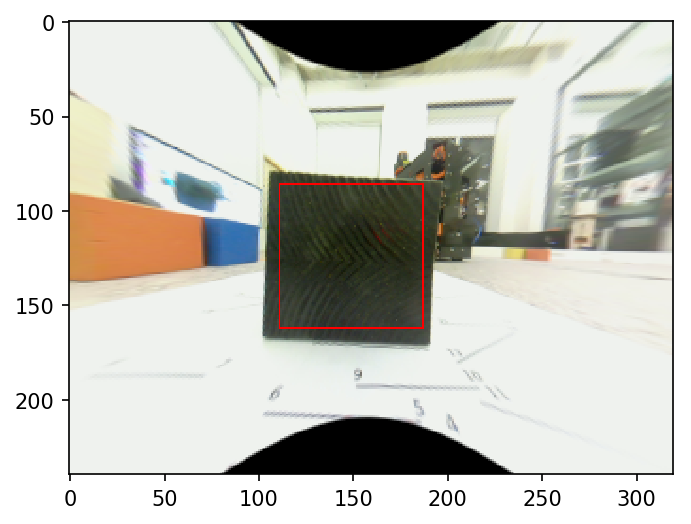

In [37]:
files = glob.glob("imgs/*.png")
center = (160, 120)
for file in files:
    img1 = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    img2 = cv2.fisheye.undistortImage(img1, K1, D, Knew = K2)
    
    labels = skimage.segmentation.felzenszwalb(img2, scale=120, sigma=3, min_size=30)
    side, xc, yc = get_params(labels==labels[center[1], center[0]])
    
    cv2.rectangle(img2, (xc + side//2, yc + side // 2), (xc - side//2, yc - side//2), (255, 0, 0))
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
    plt.imshow(img2, cmap="gray");

# Optimization

In [203]:
ALPHA = 100.
def cost_func(img, params):
    mask = np.zeros_like(img)
    mask[params[0]:params[1], params[2]:params[3]] = 1
    N = np.count_nonzero(mask[:, :, 0])
    print(N)
    var = np.std(img[params[0]:params[1], params[2]:params[3]], axis=(0, 1))
    print(var)
#     print(var)
    return N / ALPHA - np.sum(var) 

In [217]:
init_params = np.array((yc - side//2, yc + side // 2, xc - side//2, xc + side//2))
cost_func(undisort_img, params)

22650
[16.35231167 13.01557016 26.92195359]


170.21016458155736

In [170]:
input_img = undisort_img.copy()
diff_ind = np.array([[1, -1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, -1, 0, 0, 0, 0, 0], 
                     [0, 0, 0, 0, 1, -1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, -1, 0]])
params = init_params
for i in range(100):
    costs = np.zeros(9)
    for j in range(9):
        costs[j] = cost_func(input_img, params + diff_ind[:, j])
    params = params + diff_ind[:, np.argmax(costs)]

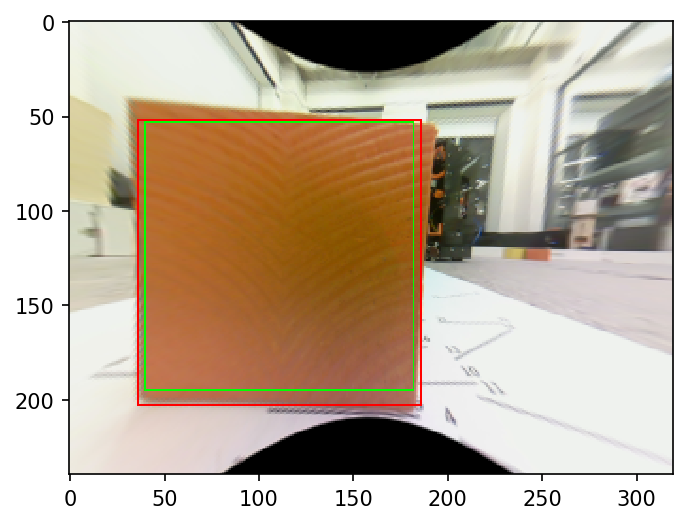

In [169]:
cv2.rectangle(input_img, (params[3], params[1]), (params[2], params[0]), (255, 0, 0))
cv2.rectangle(input_img, (init_params[3], init_params[1]), (init_params[2], init_params[0]), (0, 255, 0))
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
plt.imshow(input_img, cmap="gray");

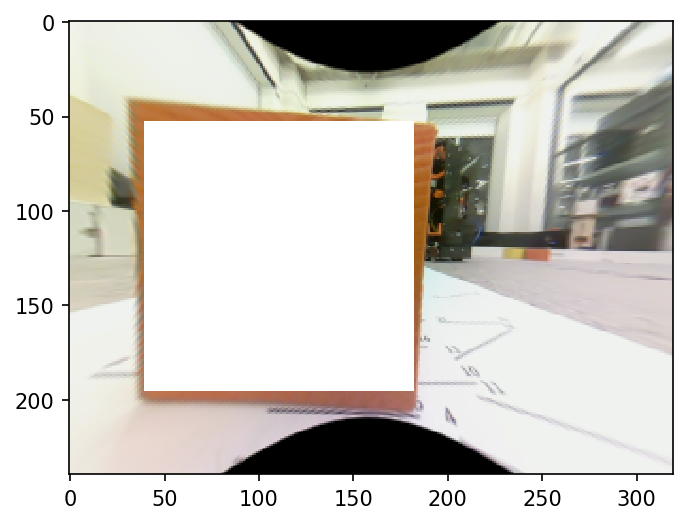

In [226]:
p = init_params.copy()
input_img = undisort_img.copy()
points = np.array([p[3], p[2], p[2], p[3], p[0], p[0], p[1], p[1]])
cv2.fillPoly(input_img, points.reshape((2, 4)). T[np.newaxis, :, :], (255, 255, 255))
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
plt.imshow(input_img, cmap="gray");

In [256]:
def new_cost_func(img, params):
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, params.reshape((2, 4)).T[np.newaxis, :, :], (1, 1, 1))
    N = np.count_nonzero(mask[:, :, 0])
#     print(N)
    mean = 1. * np.sum(mask * img, axis=(0, 1)) / N
    var = np.sqrt(1. * np.sum(mask * (img - mean) ** 2, axis=(0, 1)) / N)
    print(var)
#     print(var)
    print(N)
    return N / ALPHA - np.sum(var)

def get_new_neighbor(params):
    ind = np.random.randint(len(params))
    diff = np.random.randint(13) - 3
    params = params.copy()
    params[ind] += diff
    return params

In [260]:
def local_search(img, init_params):
    params = init_params
    cost = new_cost_func(img, params)
    for i in range(200):
        new_params = get_new_neighbor(params)
        new_cost = new_cost_func(img, new_params)
        if new_cost > cost:
            params = new_params
            cost = new_cost
    return params

opt_params = local_search(undisort_img, points)

[16.20385591  9.71321627 22.64451754]
20449
[16.20698338  9.71771016 22.75521951]
20592
[16.20698338  9.71771016 22.75521951]
20592
[16.11644649  9.26968199 22.57212957]
20521
[16.36052544 10.6814147  23.92459615]
20809
[16.12434772  9.24572323 22.59459156]
20378
[16.0307608   9.23021321 22.92248662]
20807
[16.0307608   9.23021321 22.92248662]
20807
[16.0307608   9.23021321 22.92248662]
20807
[16.10479974 11.26103618 25.57441363]
21379
[16.10887167 11.69080945 26.05325046]
21600
[16.10887167 11.69080945 26.05325046]
21600
[16.03965942 11.60611371 26.07896972]
21385
[16.09293889 11.83002254 26.20036663]
21752
[16.09293889 11.83002254 26.20036663]
21752
[16.14094399 12.28190321 26.61745435]
21826
[16.10676136 11.82673931 26.2463728 ]
21531
[16.1228564  11.81467099 26.13118705]
21600
[16.14094399 12.28190321 26.61745435]
21826
[16.05646068 11.0409852  25.29977123]
21164
[16.09293889 11.83002254 26.20036663]
21752
[16.49882609 14.24809789 28.83705193]
21969
[16.06224583 11.7706135  26.1985

[16.12370919 11.0421012  25.4864588 ]
23088
[16.64027207 14.11119066 28.46736163]
23556
[16.11414745 11.58166766 25.87901019]
23333
[16.11414745 11.58166766 25.87901019]
23333
[15.98586609 11.67682048 26.55058334]
22875
[16.15976479 11.19637216 25.87180273]
22889
[16.12370919 11.0421012  25.4864588 ]
23088
[16.01153477 11.65545951 26.47089192]
23028
[17.075448   16.4847584  31.91226918]
23940
[16.11763212 11.49985935 26.1043234 ]
23333


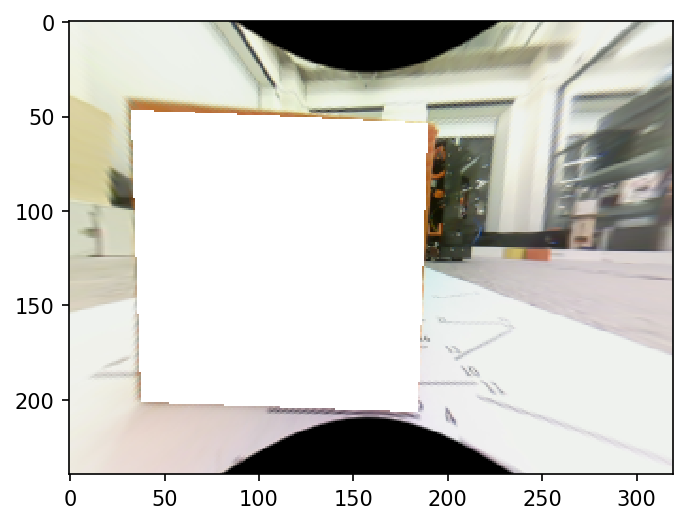

In [261]:
input_img = undisort_img.copy()
cv2.fillPoly(input_img, opt_params.reshape((2, 4)). T[np.newaxis, :, :], (255, 255, 255))
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
plt.imshow(input_img, cmap="gray");